<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/%E4%BF%AE%E6%AD%A3%E6%A8%A1%E7%B5%84%E8%A8%93%E7%B7%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt
!pip install optuna > log.txt

fatal: destination path 'c620' already exists and is not an empty directory.


# import

In [46]:
from c620.FV2 import AllSystem
from c620.configV2 import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# data

In [47]:
demo = joblib.load('data/demo(real_data).pkl')
print(demo.keys())
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']
print(icg_input.shape)
icg_input.head()

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c660_op', 'c670_op', 'c620_wt', 'c660_wt', 'c670_wt'])
(168, 17)


,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
2021-02-13,182.727005,2.060,11.670,37.270,17.901134,2.370,68.700,21.000,98.045372,0.6650,43.532,42.478,87.140,838.0,0.0,29.0,40.842743
2021-02-05,179.608627,2.165,12.377,38.074,18.646059,3.088,66.645,22.216,96.942879,0.7025,43.370,42.201,85.878,800.0,0.0,16.0,40.885593
2020-12-04,166.107956,2.151,12.047,37.287,19.038383,3.474,65.729,19.557,99.873688,0.6486,43.878,42.602,86.102,805.0,0.0,35.0,39.059292
2020-11-26,169.727284,1.360,12.000,37.630,18.240871,3.000,66.560,21.430,92.989864,0.6610,43.786,41.398,86.390,749.0,0.0,19.0,41.073098
2020-11-16,176.370055,1.837,11.857,37.198,17.663765,2.622,66.132,21.395,98.291358,0.5919,44.655,42.658,92.836,738.0,0.0,32.0,43.761401


In [48]:
f = joblib.load('/content/c620/model/allsystem.pkl')

In [49]:
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])

In [50]:
c620_op_col = demo['c620_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c620_op[c620_op_col],demo['c620_op'][c620_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,4.93398e-05,0.676215
Density_Vent Gas Production Rate and Composition,0,3.02118e-05,0.954037
Density_Distillate Production Rate and Composition,0,0.0041599,8.11123
Density_Sidedraw Production Rate and Composition,0,3.16898e-06,0.134163
Density_Bottoms Production Rate and Composition,0,6.75209e-06,0.2832
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0,541.791,14.9136
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0,235.071,8.48573
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,157.499,6.40837
AVG,0,116.796,4.99582


In [51]:
c660_op_col = demo['c660_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c660_op[c660_op_col],demo['c660_op'][c660_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,3.21904e-07,0.0446606
Density_Vent Gas Production Rate and Composition,0,0.000671065,4.04807
Density_Distillate (Benzene Drag) Production Rate and Composition,0,0.000139389,1.20888
Density_Sidedraw (Benzene )Production Rate and Composition,0,1.64029e-06,0.144911
Density_Bottoms Production Rate and Composition,0,5.32315e-08,0.0251327
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0,1932.2,21.4065
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0,1.38511,1.07435
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0,2.53836,1.31801
AVG,0,242.016,3.65882


In [52]:
c670_op_col = demo['c670_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c670_op[c670_op_col],demo['c670_op'][c670_op_col])

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,2.49069e-08,0.0176342
Density_Bottoms Production Rate and Composition,0,1.41241e-05,0.423364
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,3436.4,17.826
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,1.55257,0.425521
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,7.86373,1.10119
AVG,0,689.163,3.95874


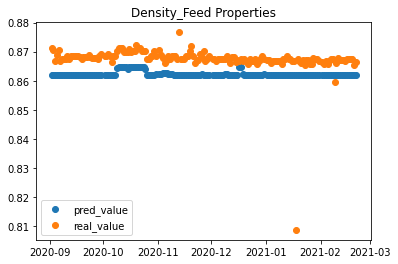

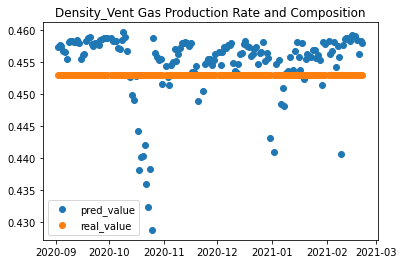

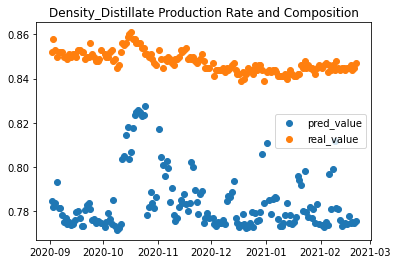

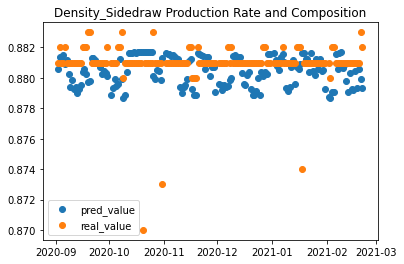

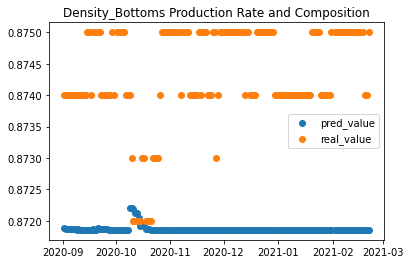

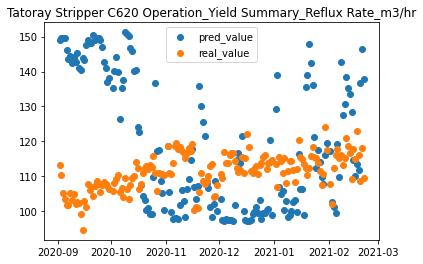

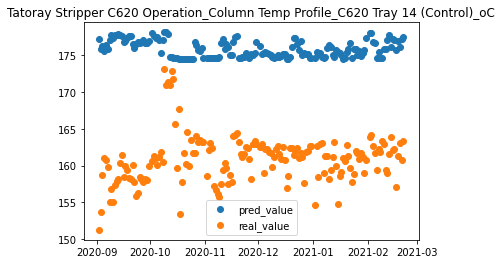

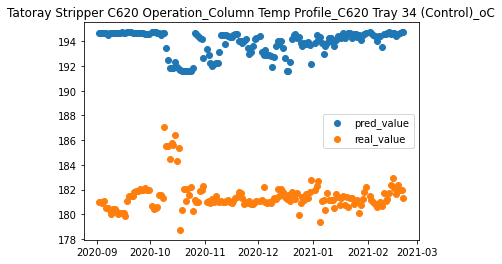

In [53]:
import matplotlib.pyplot as plt

for i in c620_op_col:
  idx = demo['icg_input'].index
  plt.scatter(idx,c620_op[i],label='pred_value')
  plt.scatter(idx,demo['c620_op'][i],label='real_value')
  plt.title(i)
  plt.legend()
  plt.show()

In [54]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import Adam

In [55]:
in_dim = len(icg_input.columns)+len(c620_feed.columns)+len(t651_feed.columns)
out_dim = len(c620_op_col)+len(c660_op_col)+len(c670_op_col)
fix_model = nn.Linear(out_dim,out_dim)
optimizer = Adam(fix_model.parameters(),lr=1e-3)

In [56]:
from torch.nn import SmoothL1Loss
def train(model,optimizer,epochs=100):
  history = []
  for e in range(epochs):
    c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])
    y_pred = torch.cat((torch.FloatTensor(c620_op[c620_op_col].values),torch.FloatTensor(c660_op[c660_op_col].values),torch.FloatTensor(c670_op[c670_op_col].values)),dim=1).detach()
    y_pred_fix = fix_model(y_pred)
    y_real = torch.cat((torch.FloatTensor(demo['c620_op'][c620_op_col].values),torch.FloatTensor(demo['c660_op'][c660_op_col].values),torch.FloatTensor(demo['c670_op'][c670_op_col].values)),dim=1)
    
    # 預測誤差
    loss = SmoothL1Loss()(y_pred_fix,y_real)
    
    # L1正則
    L1_reg = torch.tensor(0., requires_grad=True)
    for name, param in fix_model.named_parameters():
      if 'weight' in name:
        L1_reg = L1_reg + torch.norm(param, 1)
    
    # 總損失
    loss = loss.mean() + 10e-4 * L1_reg
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    if e % 10 == 0:
      print(f'ep:{e} loss{loss.item()}')
    history.append(loss.item())
  return model,history

In [57]:
fix_model,history = train(fix_model,optimizer,epochs=1000)

ep:0 loss101.03617858886719
ep:10 loss87.16315460205078
ep:20 loss73.69364929199219
ep:30 loss62.23652648925781
ep:40 loss52.32249450683594
ep:50 loss43.506717681884766
ep:60 loss35.19343185424805
ep:70 loss29.489219665527344
ep:80 loss24.095827102661133
ep:90 loss18.902786254882812
ep:100 loss14.282362937927246
ep:110 loss10.530957221984863
ep:120 loss9.032885551452637
ep:130 loss8.10280704498291
ep:140 loss7.186114311218262
ep:150 loss6.358221054077148
ep:160 loss5.537045001983643
ep:170 loss4.794808387756348
ep:180 loss4.189570426940918
ep:190 loss3.9054415225982666
ep:200 loss3.839282274246216
ep:210 loss3.777440309524536
ep:220 loss3.705030918121338
ep:230 loss3.6440865993499756
ep:240 loss3.5864474773406982
ep:250 loss3.5308175086975098
ep:260 loss3.478612184524536
ep:270 loss3.429353713989258
ep:280 loss3.3820927143096924
ep:290 loss3.3361546993255615
ep:300 loss3.290999174118042
ep:310 loss3.2462337017059326
ep:320 loss3.201648712158203
ep:330 loss3.1571731567382812
ep:340 loss

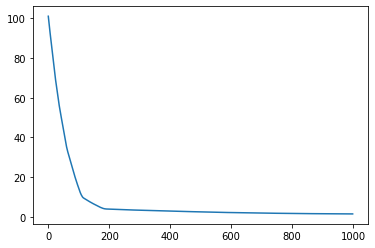

In [58]:
import matplotlib.pyplot as plt

plt.plot(history)

In [59]:
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])

In [60]:
op_pred = fix_model(torch.cat((torch.FloatTensor(c620_op[c620_op_col].values),torch.FloatTensor(c660_op[c660_op_col].values),torch.FloatTensor(c670_op[c670_op_col].values)),dim=1))
op_pred = pd.DataFrame(op_pred.detach().numpy(),index=demo['icg_input'].index)
c620_op = op_pred.iloc[:,:8]
c660_op = op_pred.iloc[:,8:16]
c670_op = op_pred.iloc[:,-5:]
c620_op.columns = c620_op_col
c660_op.columns = c660_op_col
c670_op.columns = c670_op_col

In [61]:
f.c670_M.show_metrics(c620_op[c620_op_col],demo['c620_op'][c620_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,0.376105,140.195
Density_Vent Gas Production Rate and Composition,0,0.994668,37.5203
Density_Distillate Production Rate and Composition,0,0.637418,15.6343
Density_Sidedraw Production Rate and Composition,0,1.3898,20.5553
Density_Bottoms Production Rate and Composition,0,0.0507181,19.4251
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0,22.847,3.42138
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0,13.6744,1.61248
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,6.21083,0.661749
AVG,0,5.77262,29.8782


In [62]:
f.c670_M.show_metrics(c660_op[c660_op_col],demo['c660_op'][c660_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,0.961475,29.1932
Density_Vent Gas Production Rate and Composition,0,0.27435,18.4782
Density_Distillate (Benzene Drag) Production Rate and Composition,0,0.314064,12.7593
Density_Sidedraw (Benzene )Production Rate and Composition,0,0.660355,19.3858
Density_Bottoms Production Rate and Composition,0,2.52609,37.4165
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0,120.293,6.9632
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0,4.08295,1.0231
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0,1.04133,0.899893
AVG,0,16.2692,15.7649


In [63]:
f.c670_M.show_metrics(c670_op[c670_op_col],demo['c670_op'][c670_op_col])

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,2.57676,46.7338
Density_Bottoms Production Rate and Composition,0,0.289333,14.3859
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,198.911,3.8805
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,3.59797,0.734458
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,12.0762,0.661555
AVG,0,43.4903,13.2792


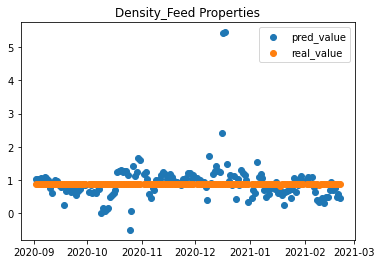

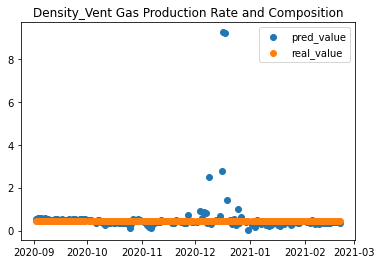

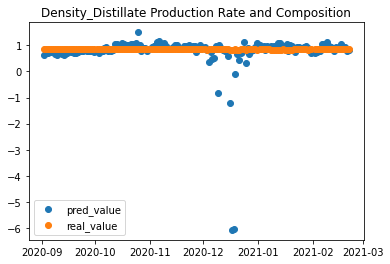

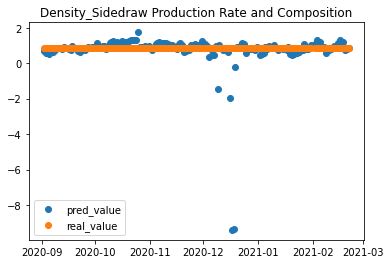

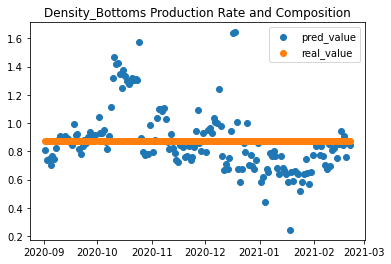

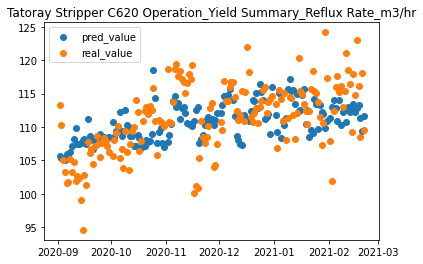

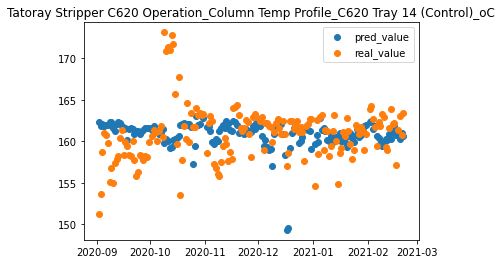

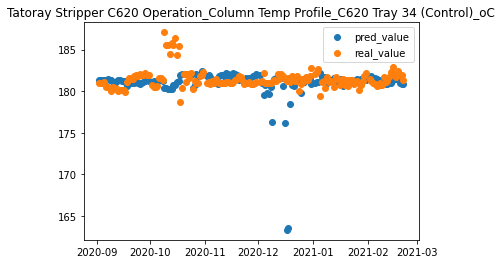

In [64]:
for i in c620_op_col:
  idx = demo['icg_input'].index
  plt.scatter(idx,c620_op[i],label='pred_value')
  plt.scatter(idx,demo['c620_op'][i],label='real_value')
  plt.title(i)
  plt.legend()
  plt.show()

In [65]:
import joblib

In [67]:
joblib.dump(fix_model,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/fix_model.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/fix_model.pkl']